# Packages & Imports

In [ ]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Loading Data and Subdividing into Smaller Batches

In [3]:
# reading the 04-05 data from the csv
df = pd.read_csv('dataset/Solar_flare_RHESSI_2004_05.csv')

# changing the month values for the year 2005 (1 = 13, 2 = 14, etc.) to make subdivision simpler later on
# in rows where the year value is 2005, add 12 to the month value and replace the old month value
df['month'] = np.where((df['year'] == 2005), df['month'] + 12, df['month'])

# verify by checking the last 5 rows of the data (year/month should be 2005, 24)
df.tail()

,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,...,flag.4,flag.5,dt.start,dt.peak,dt.end,year,month,day,energy.kev.i,energy.kev.f
17501,704,24,72312.0,6-12,-279,229,362,841,A0,DF,...,P1,Q2,2005-12-29 21:38:40,2005-12-29 21:39:50,2005-12-29 21:50:24,2005,24,29,6,12
17502,212,22,24624.0,6-12,-402,238,468,841,A0,DF,...,Q1,NaN,2005-12-29 22:07:16,2005-12-29 22:08:18,2005-12-29 22:10:48,2005,24,29,6,12
17503,584,184,332976.0,6-12,-251,243,350,843,A0,GD,...,GS,P1 PE Q4,2005-12-30 16:47:04,2005-12-30 16:50:02,2005-12-30 16:56:48,2005,24,30,6,12
17504,512,56,101424.0,6-12,-250,228,339,0,A0,P1,...,Q1,NaN,2005-12-30 20:18:20,2005-12-30 20:21:22,2005-12-30 20:26:52,2005,24,30,6,12
17505,292,18,25416.0,6-12,879,-216,906,844,A0,DF,...,Q1,NaN,2005-12-30 21:49:12,2005-12-30 21:49:30,2005-12-30 21:54:04,2005,24,30,6,12


In [4]:
# list that will hold sets of 4 with a two month overlap
dfs = []

# grouping the data frame by month nummber
df_m = df.groupby(['month'])

# looping starting at i = 4, in steps of 2, while i < 25
for i in range(4, 25, 2):
    # get groups for i - 3th, i - 2th, i - 1th, and ith months, 
    # concatenate them into a single data frame, then append this to the dfs list
    dfs.append(pd.concat([df_m.get_group(i - 3), df_m.get_group(i - 2), df_m.get_group(i - 1), df_m.get_group(i)]))


# Intensity Estimation

## Method 1: Intensity Based on `total.counts`

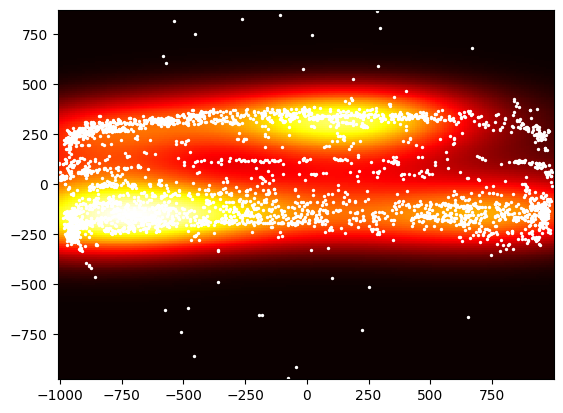

In [5]:
# taking the (x, y) coordinates, and weights of each solar flare in months 1 to 4 in a new data structure
flares = dfs[0]
# flatten() will turn the column into a 1D array like [1, 2, 3, 4, ..]
x = flares['x.pos.asec'].values.flatten()
y = flares['y.pos.asec'].values.flatten()
counts = flares['total.counts'].values.flatten()

# taking a grid of sample locations
xx, yy = np.mgrid[x.min():x.max():200j, 
                  y.min():y.max():200j]

# sample and training data
sample = np.vstack([xx.ravel(), yy.ravel()])
train = np.vstack([x, y])

# gaussian kernel, bandwidth of 0.5, using the counts as weights
kde_sci = stats.gaussian_kde(train, bw_method=0.5, weights=counts.T)

# taking the density estimates of the sample data and shaping it into a grid
zz = np.reshape(kde_sci(sample), xx.shape)

# creating a color mesh using the grids for the x and y coordinates, as well as the density estimations
plt.pcolormesh(xx, yy, zz, cmap='hot')
# plotting the locations for each solar flare on the mesh
plt.scatter(x, y, s=2, facecolor='white')
# saving the figure in the outputs folder
plt.savefig('./output/intensity_frequency.png')

## Method 2: Intensity Based on `duration.s` and `energy.kev`